In [ ]:
# import os
# import utils
# data_dir = "test_data/"
# if not os.path.exists(data_dir):
#     os.mkdir(data_dir)

In [ ]:
# utils.fetch_yf_data('AAPL', data_dir, '2019-01-01', '2020-01-01')
# utils.fetch_yf_data('AAPL', data_dir, '2018-12-31', '2020-01-01')
# utils.fetch_yf_data('AAPL', data_dir, '2000-01-01')

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2019-01-02,37.708591,39.480000,39.712502,38.557499,38.722500,148158800
2019-01-03,33.952538,35.547501,36.430000,35.500000,35.994999,365248800
2019-01-04,35.401955,37.064999,37.137501,35.950001,36.132500,234428400
2019-01-07,35.323147,36.982498,37.207500,36.474998,37.174999,219111200
2019-01-08,35.996525,37.687500,37.955002,37.130001,37.389999,164101200
...,...,...,...,...,...,...
2019-12-24,68.898689,71.067497,71.222504,70.730003,71.172501,48478800
2019-12-26,70.265678,72.477501,72.495003,71.175003,71.205002,93121200


# Test Metrics

In [1]:
import os
from metrics import *
import plotting
data_dir = "test_data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
start_date = '2000-01-01'
end_date = '2024-01-01'

In [2]:
def showMetricsCalculation(metric : Metric, y_axis = ["left", "right", "right"]):
    # plot all stages (data, processed, result)
    graph_list = [
        plotting.Graph(metric.data, y_axis=y_axis[0], df_color="black", df_label="data"), 
        plotting.Graph(metric.processed, y_axis=y_axis[1], df_color="blue", df_label="processed"), 
        plotting.Graph(metric.result, y_axis=y_axis[2], df_color="red", df_label="result")
    ]
    plotting.plot_graph(graph_list, neutral_line=None, title=metric.name)

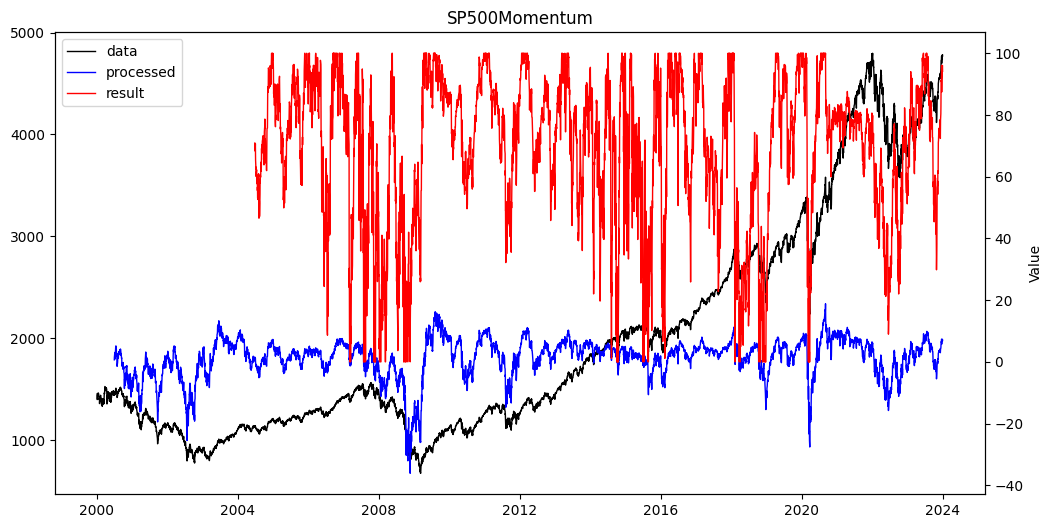

In [3]:
Metric.setPreferences(data_dir, start_date, end_date)
metrics = []
metrics.append(SP500Momentum())
for metric in metrics:
    metric.get()
    showMetricsCalculation(metric)